Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

# **Loading dataset**

This dataset consists of the scanned images of brain of patient diagnosed of brain tumour.

In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

In [3]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d preetviradiya/brian-tumor-dataset

 90% 97.0M/107M [00:01<00:00, 72.5MB/s]
100% 107M/107M [00:01<00:00, 82.7MB/s] 


In [ ]:
!unzip brian-tumor-dataset

In [6]:
import os
import pandas as pd


tumor_dir = r'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir = r'Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
dir_list = [tumor_dir, healthy_dir]
image_path = []
label = []

for i, j in enumerate(dir_list):
    images_list = os.listdir(j)
    for f in images_list:
        image_path.append(j + "/" + f)
        if i == 0:
            label.append('Cancer')
        else:
            label.append('Not Cancer')

data = pd.DataFrame({'image_path': image_path, 'label': label})

In [7]:
data.head()

,image_path,label
0,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,Cancer
1,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,Cancer
2,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,Cancer
3,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,Cancer
4,Brain Tumor Data Set/Brain Tumor Data Set/Brai...,Cancer


In [8]:
data.shape

(4600, 2)

In [9]:
data['label'].value_counts()

Cancer        2513
Not Cancer    2087
Name: label, dtype: int64

# **Split data into train, validation, test**

Split the data into train, validation and test sets with percentages of 80%, 10% and 10% respectively.

In [10]:
from sklearn.model_selection import train_test_split
seed = 123

# Chia dữ liệu thành tập train và tập còn lại
train_set, remain_set = train_test_split(data, test_size=0.2, random_state=seed)

# Chia tập còn lại thành tập validation và tập test
val_set, test_set = train_test_split(remain_set, test_size=0.5, random_state=seed)

In [11]:
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(3680, 2)
(460, 2)
(460, 2)


# **ImageDataGenerator**

In [12]:
#Generate batches of tensor image data with real-time data augmentation.
image_generator = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_generator.flow_from_dataframe(dataframe = train_set, x_col = "image_path", y_col ="label",
                                      target_size = (244, 244),
                                      color_mode = 'rgb',
                                      class_mode = "categorical",
                                      batch_size = 32,
                                      shuffle = False
                                     )
val = image_generator.flow_from_dataframe(dataframe = val_set, x_col ="image_path", y_col ="label",
                                    target_size=(244, 244),
                                    color_mode = 'rgb',
                                    class_mode = "categorical",
                                    batch_size = 32,
                                    shuffle = False
                                   )
test = image_generator.flow_from_dataframe(dataframe = test_set, x_col = "image_path", y_col ="label",
                                     target_size = (244, 244),
                                     color_mode = 'rgb',
                                     class_mode = "categorical",
                                     batch_size = 32,
                                     shuffle = False
                                    )

Found 3680 validated image filenames belonging to 2 classes.
Found 460 validated image filenames belonging to 2 classes.
Found 460 validated image filenames belonging to 2 classes.


# **Visualize some images**

In [13]:
import matplotlib.pyplot as plt

def show_images(image_generator):
    img, label = image_generator.next()
    plt.figure(figsize=(20,20))
    for i in range(15):
        plt.subplot(5, 5, i+1)

        plt.imshow((img[i]+1)/2)  #scale images between 0 and 1

        idx = np.argmax(label[i])
        if idx == 0:
            plt.title('Cancer')
        else:
            plt.title('Not Cancer')
        plt.axis('off')
    plt.show()

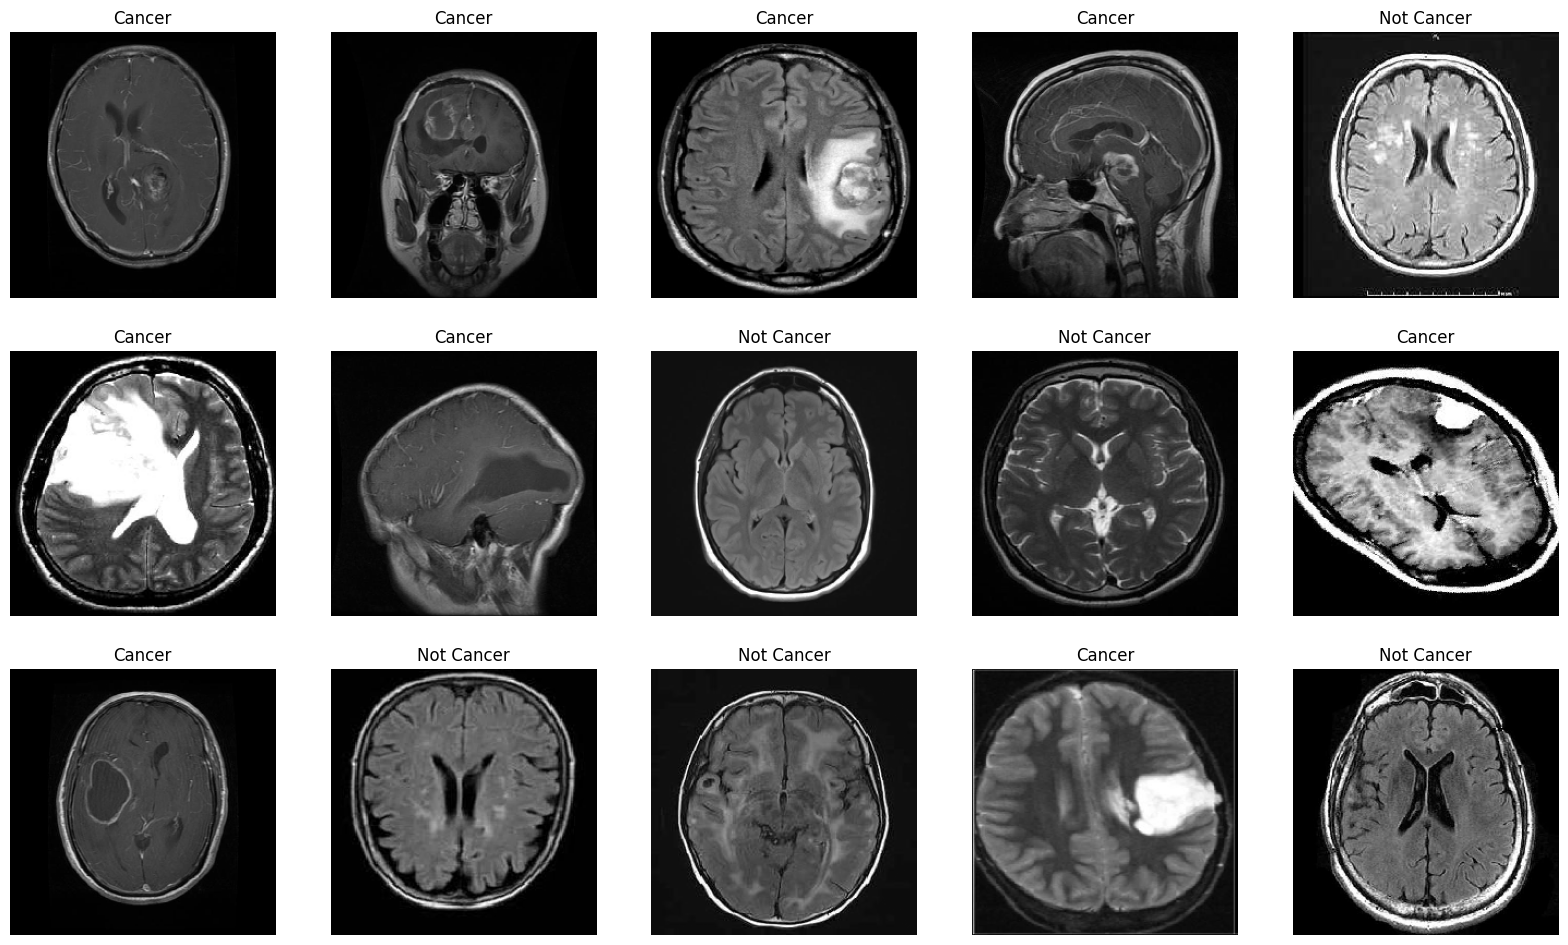

In [14]:
show_images(train)

# **Train Model**

In [15]:
# Thiết lập Convolutional Neural Networks (CNN):

import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(244, 244, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs=10, verbose=1, validation_data = val)


Epoch 1/10
115/115 [==============================] - 1311s 11s/step - loss: 3.1010 - accuracy: 0.6742 - val_loss: 0.3472 - val_accuracy: 0.8783
Epoch 2/10
115/115 [==============================] - 1284s 11s/step - loss: 0.2459 - accuracy: 0.9087 - val_loss: 0.1274 - val_accuracy: 0.9630
Epoch 3/10
115/115 [==============================] - 1277s 11s/step - loss: 0.0912 - accuracy: 0.9685 - val_loss: 0.0988 - val_accuracy: 0.9652
Epoch 4/10
115/115 [==============================] - 1332s 12s/step - loss: 0.0552 - accuracy: 0.9812 - val_loss: 0.0973 - val_accuracy: 0.9739
Epoch 5/10
115/115 [==============================] - 1292s 11s/step - loss: 0.0323 - accuracy: 0.9875 - val_loss: 0.1113 - val_accuracy: 0.9717
Epoch 6/10
115/115 [==============================] - 1311s 11s/step - loss: 0.0266 - accuracy: 0.9905 - val_loss: 0.1038 - val_accuracy: 0.9739
Epoch 7/10
115/115 [==============================] - 1287s 11s/step - loss: 0.0211 - accuracy: 0.9908 - val_loss: 0.1308 - val_ac

# Plot Accuracy and Loss

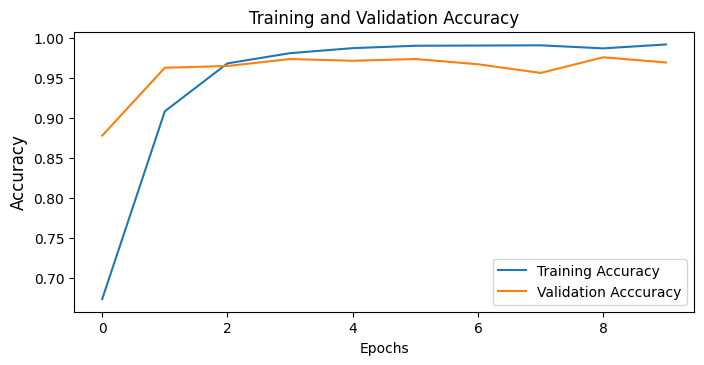

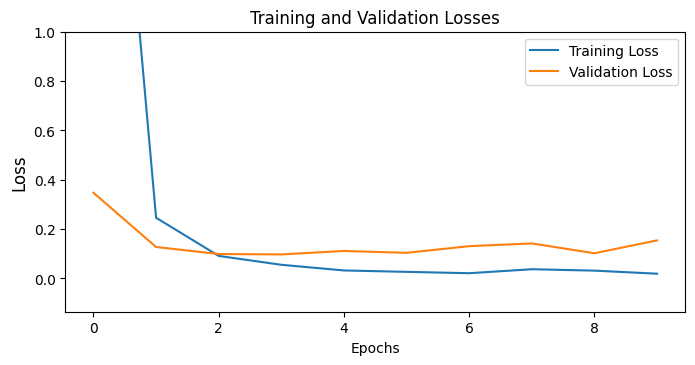

In [16]:
# Accuracy
acc = history.history["accuracy"] # report of model
val_acc = history.history["val_accuracy"] # history of validation data

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns

plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss
loss = history.history["loss"]        # Training loss
val_loss = history.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)

plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

# **Predict test set**

In [17]:
model.evaluate(test, verbose=1)

15/15 [==============================] - 38s 3s/step - loss: 0.1230 - accuracy: 0.9717


[0.1230454370379448, 0.9717391133308411]

In [18]:
pred = model.predict(test)
y_pred = np.argmax(pred, axis=1)

15/15 [==============================] - 41s 3s/step


In [19]:
y_test = test.labels
y_test = np.array(y_test)

In [20]:
from sklearn.metrics import accuracy_score

print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

Accuracy of the Model: 97.17391304347827 %


<Axes: >

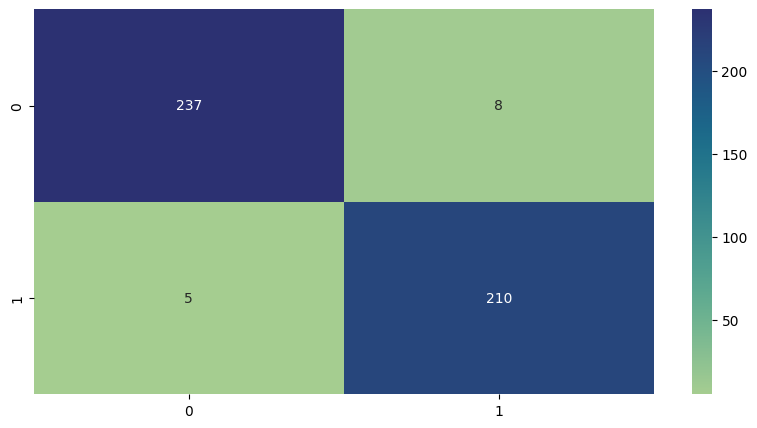

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score

plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'g', cmap = 'crest')

# **Early Stopping**

To save training time we can stop training the CNN if the accuracy of the validation data does not improve after a certain number of steps. For example, the selection criteria is Accuracy on Validation data and the algorithm will stop after 5 steps.

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(244, 244, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, min_delta=1)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(train, epochs=10, verbose=1, validation_data = val, callbacks=[early_stop])

Epoch 1/10
115/115 [==============================] - 1307s 11s/step - loss: 2.7671 - accuracy: 0.7293 - val_loss: 0.2682 - val_accuracy: 0.8891
Epoch 2/10
115/115 [==============================] - 1222s 11s/step - loss: 0.1555 - accuracy: 0.9438 - val_loss: 0.1146 - val_accuracy: 0.9565
Epoch 3/10
115/115 [==============================] - 1259s 11s/step - loss: 0.0406 - accuracy: 0.9875 - val_loss: 0.0893 - val_accuracy: 0.9630
Epoch 4/10
115/115 [==============================] - 1248s 11s/step - loss: 0.0246 - accuracy: 0.9929 - val_loss: 0.0933 - val_accuracy: 0.9696
Epoch 5/10
115/115 [==============================] - 1245s 11s/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.1103 - val_accuracy: 0.9652
Epoch 6/10
115/115 [==============================] - 1270s 11s/step - loss: 0.0141 - accuracy: 0.9962 - val_loss: 0.0959 - val_accuracy: 0.9739


In [23]:
print('Train Accuracy with Early Stopping:', model_2.evaluate(test, verbose=1))

15/15 [==============================] - 36s 2s/step - loss: 0.0965 - accuracy: 0.9717
Train Accuracy with Early Stopping: [0.09646687656641006, 0.9717391133308411]


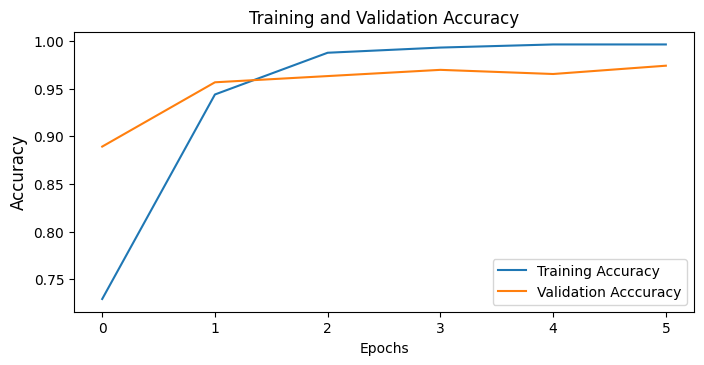

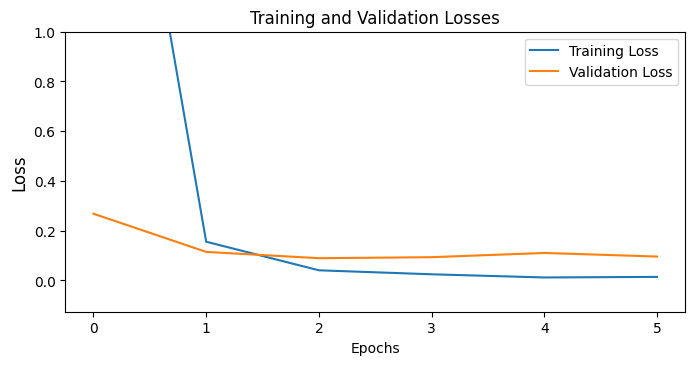

In [24]:
# Accuracy
acc = history_2.history["accuracy"] # report of model
val_acc = history_2.history["val_accuracy"] # history of validation data

plt.figure(figsize=(8,8))
plt.subplot(2,1,1) # 2 rows and 1 columns

plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Acccuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss
loss = history_2.history["loss"]        # Training loss
val_loss = history_2.history["val_loss"] # validation loss

plt.figure(figsize=(8,8))
plt.subplot(2,1,2)

plt.plot(loss, label="Training Loss")      #Training loss
plt.plot(val_loss, label="Validation Loss") # Validation Loss

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Losses", fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()